In [128]:
import sympy as sp
from sympy.abc import x, y, z
from sympy import init_printing
init_printing()
N = sp.vector.CoordSys3D('N')

In [129]:
Mx, My, Mz = sp.symbols('M_x M_y M_z', cls=sp.Function)
D1, D2 = sp.symbols('D_1 D_2')
dl = sp.Symbol('\delta l')

def cross(a, b):
    return (a[1]*b[2] - a[2]*b[1],
            a[2]*b[0] - a[0]*b[2],
            a[0]*b[1] - a[1]*b[2])

def LI(i, j, k):
    """
    Symbolic representation of the Lifshitz Invariant
    
    $ L_{ij}^{(k)) $
    
    """
    Mi, Mj = sp.symbols(f'M_{str(i)} M_{str(j)}', cls=sp.Function)
    
    return Mi(x,y,z)*sp.diff(Mj(x, y, z), k) - Mj(x,y,z)*sp.diff(Mi(x,y,z), k)


def VarDeriv(w):
    Fx = sp.diff(w, Mx(x, y, z)) - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), z)), z)

    Fy = sp.diff(w, My(x, y, z)) - sp.diff(sp.diff(w, sp.diff(My(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(My(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(My(x, y, z), z)), z)

    Fz = sp.diff(w, Mz(x, y, z)) - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), z)), z)
    
    return sp.simplify(Fx)*N.x + sp.simplify(Fy)*N.y + sp.simplify(Fz)*N.z


def discretised_form(field):
    subs = {N.x:N.i, N.y:N.j, N.z:N.k}
    disc = sp.as_finite_diff(field, 2*dl).expand()
    xm =  sp.Add(*[argi for argi in disc.args if Mx(-dl + x, y, z) in argi.atoms(sp.Function)])
    xm += sp.Add(*[argi for argi in disc.args if My(-dl + x, y, z) in argi.atoms(sp.Function)])
    xm += sp.Add(*[argi for argi in disc.args if Mz(-dl + x, y, z) in argi.atoms(sp.Function)])
    xp =  sp.Add(*[argi for argi in disc.args if Mx(x + dl, y, z) in argi.atoms(sp.Function)])
    xp += sp.Add(*[argi for argi in disc.args if My(x + dl, y, z) in argi.atoms(sp.Function)])
    xp += sp.Add(*[argi for argi in disc.args if Mz(x + dl, y, z) in argi.atoms(sp.Function)])
    ym =  sp.Add(*[argi for argi in disc.args if Mx(x, y - dl, z) in argi.atoms(sp.Function)])
    ym += sp.Add(*[argi for argi in disc.args if My(x, y - dl, z) in argi.atoms(sp.Function)])
    ym += sp.Add(*[argi for argi in disc.args if Mz(x, y - dl, z) in argi.atoms(sp.Function)])
    yp =  sp.Add(*[argi for argi in disc.args if Mx(x, y + dl, z) in argi.atoms(sp.Function)])
    yp += sp.Add(*[argi for argi in disc.args if My(x, y + dl, z) in argi.atoms(sp.Function)])
    yp += sp.Add(*[argi for argi in disc.args if Mz(x, y + dl, z) in argi.atoms(sp.Function)])
    zm =  sp.Add(*[argi for argi in disc.args if Mx(x, y, z - dl) in argi.atoms(sp.Function)])
    zm += sp.Add(*[argi for argi in disc.args if My(x, y, z - dl) in argi.atoms(sp.Function)])
    zm += sp.Add(*[argi for argi in disc.args if Mz(x, y, z - dl) in argi.atoms(sp.Function)])
    zp =  sp.Add(*[argi for argi in disc.args if Mx(x, y, z + dl) in argi.atoms(sp.Function)])
    zp += sp.Add(*[argi for argi in disc.args if My(x, y, z + dl) in argi.atoms(sp.Function)])
    zp += sp.Add(*[argi for argi in disc.args if Mz(x, y, z + dl) in argi.atoms(sp.Function)])
    return xm.subs(subs), xp.subs(subs), ym.subs(subs), yp.subs(subs), zm.subs(subs), zp.subs(subs)




# Crystal Class T

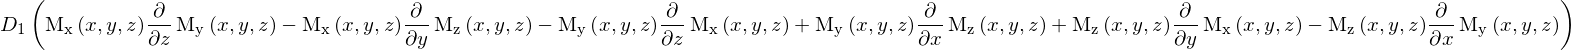

In [130]:
T = D1 * (LI(x, y, z) + LI(y, z, x) + LI(z, x, y))
T

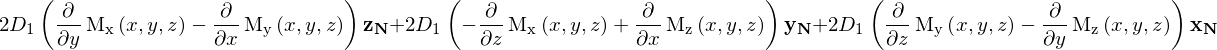

In [131]:
F_T = VarDeriv(T)
F_T

/Users/ryan/.anaconda3/envs/fidimag/lib/python3.6/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


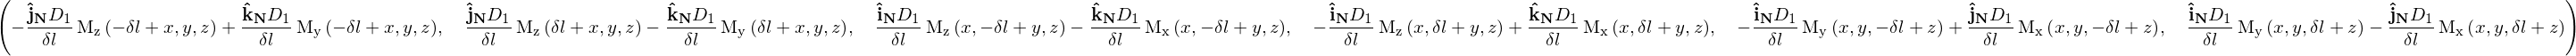

In [134]:
xm, xp, ym, yp, zm, zp = discretised_form(F_T)
xm , xp, ym, yp, zm, zp

# Crystal Class C_nv

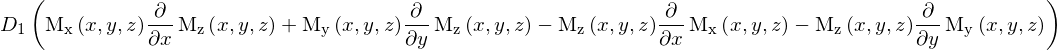

In [138]:
C_nv = D1 * (LI(x, z, x) + LI(y, z, y))
C_nv

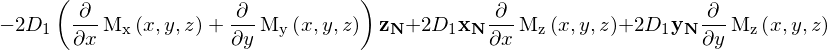

In [139]:
F_C_nv = VarDeriv(C_nv)
F_C_nv

/Users/ryan/.anaconda3/envs/fidimag/lib/python3.6/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


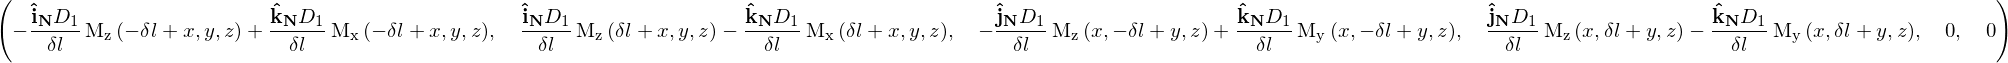

In [140]:
xm,xp,ym,yp,zm,zp = discretised_form(F_C_nv)
xm , xp, ym, yp, zm, zp

# Crystal Class D_2d

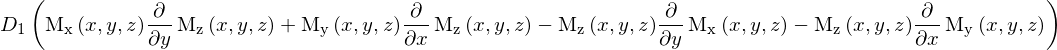

In [141]:
D_2d = D1 * (LI(y, z, x) + LI(x, z, y))
D_2d

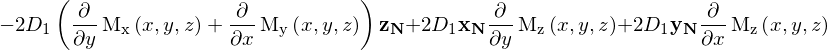

In [142]:
F_D_2d = VarDeriv(D_2d)
F_D_2d

/Users/ryan/.anaconda3/envs/fidimag/lib/python3.6/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


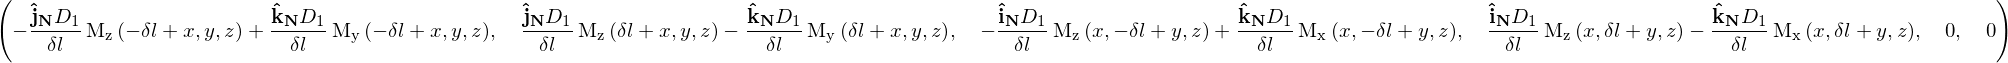

In [143]:
xm, xp, ym, yp, zm, zp = discretised_form(F_D_2d)
xm , xp, ym, yp, zm, zp

# D_n

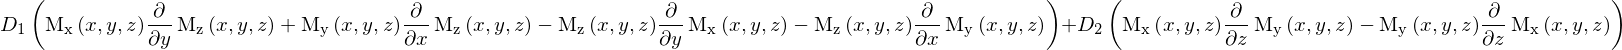

In [146]:
D_n = D1 * (LI(y, z, x) + LI(x, z, y)) + D2 * LI(x, y, z)
D_n

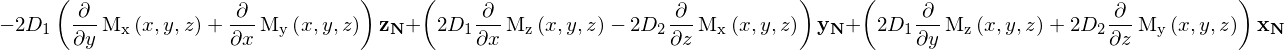

In [147]:
F_D_n = VarDeriv(D_n)
F_D_n

/Users/ryan/.anaconda3/envs/fidimag/lib/python3.6/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


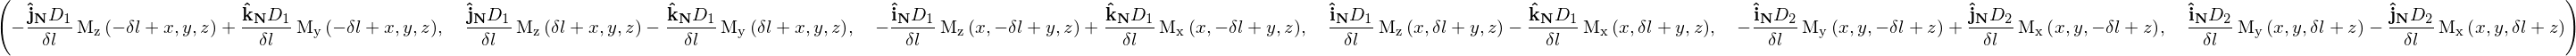

In [148]:
xm, xp, ym, yp, zm, zp = discretised_form(F_D_n)
xm , xp, ym, yp, zm, zp

# C_n

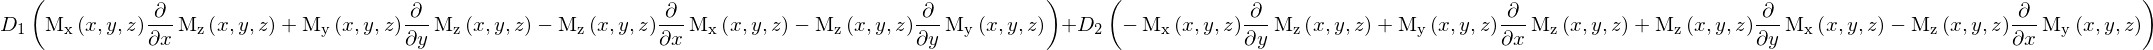

In [149]:
C_n = D1 * (LI(y, z, y) + LI(x, z, x)) + D2 * (LI(y, z, x) - LI(x, z, y))
C_n

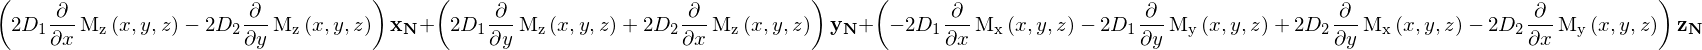

In [150]:
F_C_n = VarDeriv(C_n)
F_C_n

/Users/ryan/.anaconda3/envs/fidimag/lib/python3.6/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


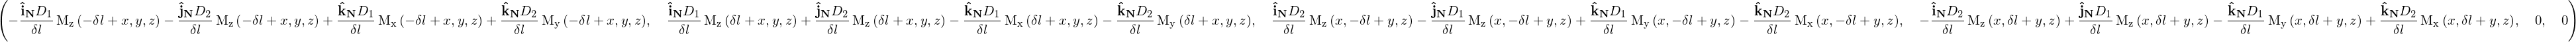

In [152]:
xm, xp, ym, yp, zm, zp = discretised_form(F_C_n)
xm , xp, ym, yp, zm, zp

In [ ]:
D1:
    j
    j
    i
    i
    0
    0
        
D2: 
    
    
    